Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.U93SU4_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.U93SU4_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


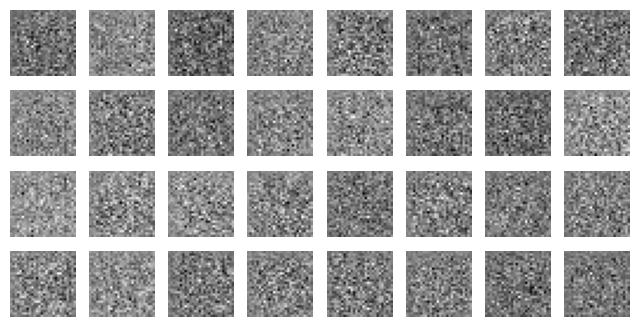

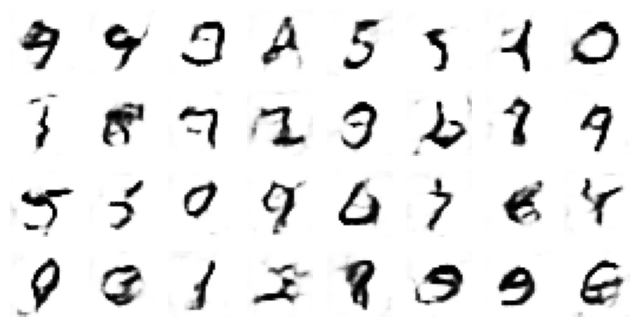

Epoch 2/15


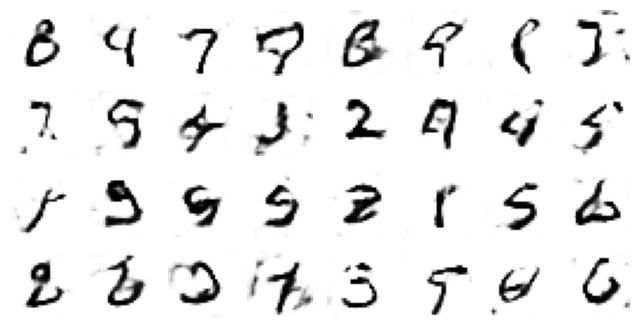

Epoch 3/15


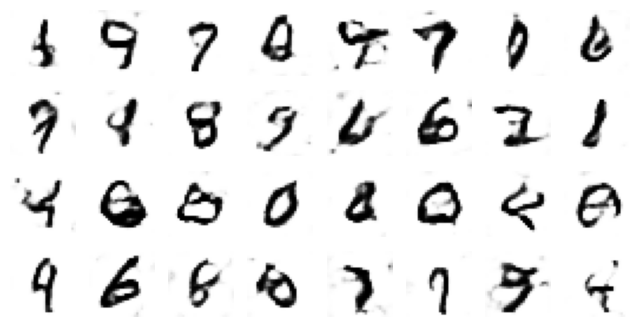

Epoch 4/15


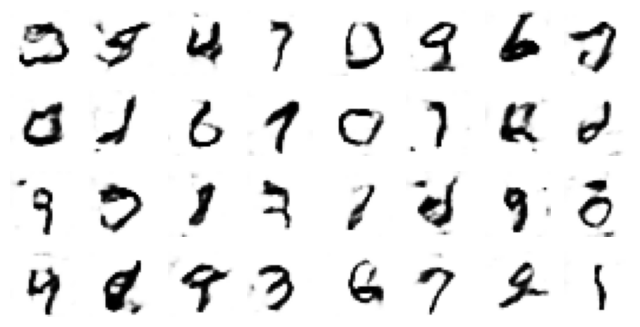

Epoch 5/15


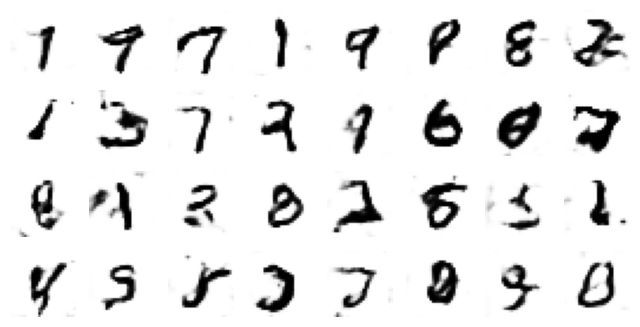

Epoch 6/15


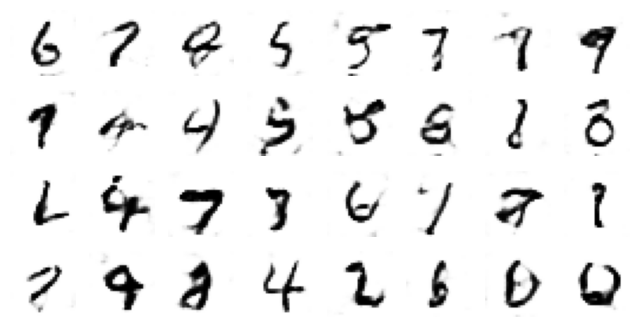

Epoch 7/15


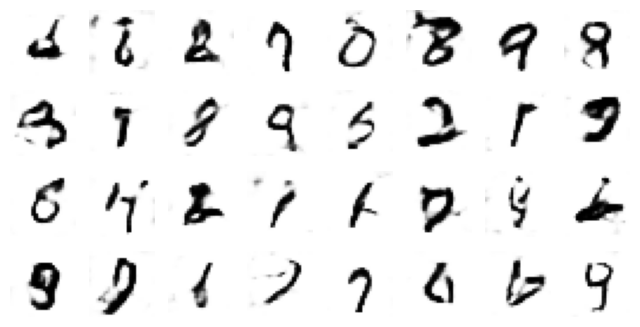

Epoch 8/15


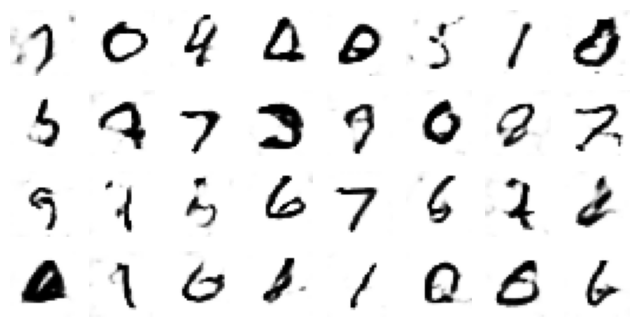

Epoch 9/15


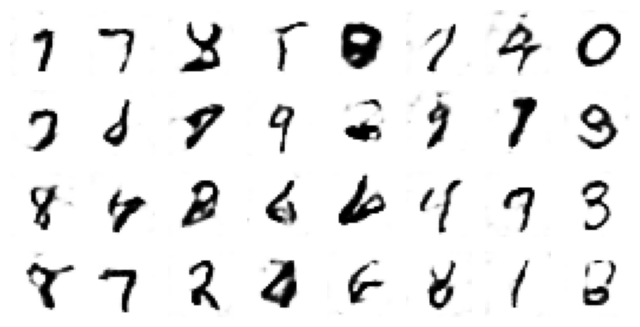

Epoch 10/15


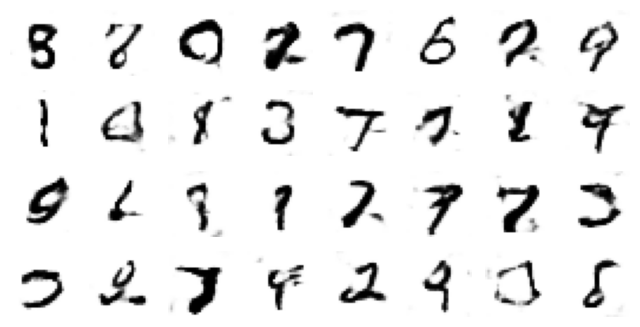

Epoch 11/15


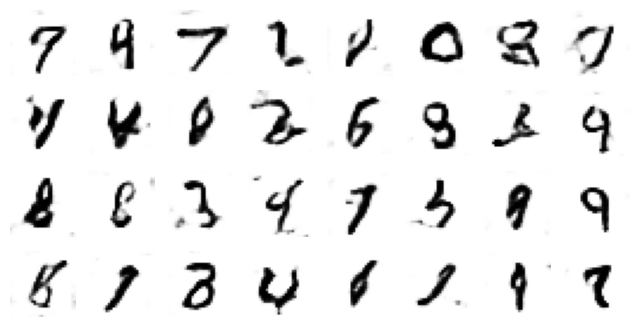

Epoch 12/15


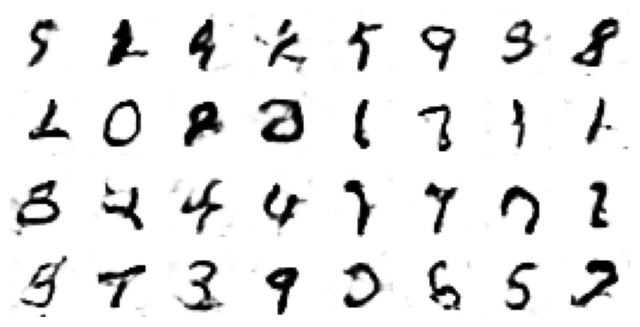

Epoch 13/15


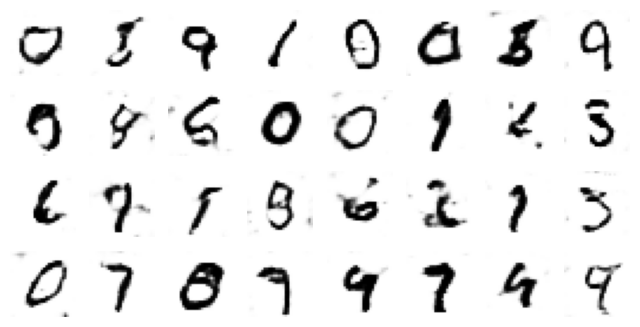

Epoch 14/15


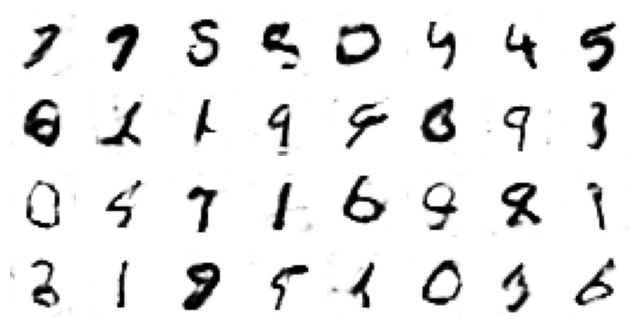

Epoch 15/15


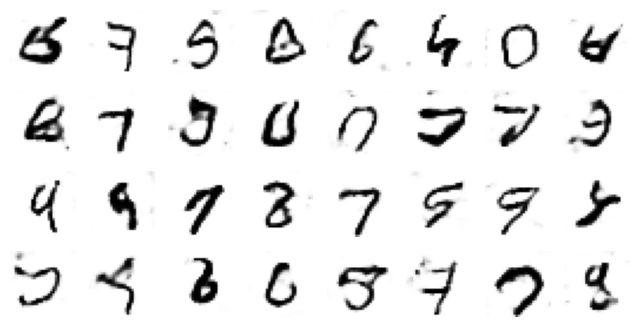

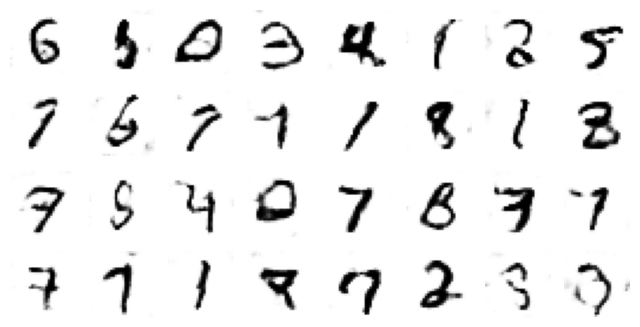

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

tf.__version__, tf.test.gpu_device_name()

x_train_img, _ = tfds.as_numpy(tfds.load('mnist', split='train', batch_size=-1, as_supervised=True, try_gcs=True, shuffle_files=True))

len(x_train_img)

images = x_train_img.astype(np.float32) / 255
images.shape

x_train_img[0][0], images[0][0]

in_shape = images.shape[1:]
in_shape

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    for X_batch in dataset:
      noise = tf.random.normal(shape=[batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    plot_multiple_images(generated_images, 8)
    plt.show()

def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

codings_size = 100
dc_generator = Sequential\
  ([
    Dense(7 * 7 * 128, input_shape=[codings_size]),
    Reshape([7, 7, 128]),
    BatchNormalization(),
    Conv2DTranspose(64, kernel_size=5, strides=2, padding='SAME', activation='selu'),
    BatchNormalization(),
    Conv2DTranspose(1, kernel_size=5, strides=2, padding='SAME', activation='tanh'),
  ])

tf.random.set_seed(0)
np.random.seed(0)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = dc_generator(noise)
plot_multiple_images(generated_images, 8)

dc_discriminator = Sequential\
  ([
    Conv2D(64, kernel_size=5, strides=2, padding='SAME', activation=LeakyReLU(0.2), input_shape=[28, 28, 1]),
    Dropout(0.4),
    Conv2D(128, kernel_size=5, strides=2, padding='SAME', activation=LeakyReLU(0.2)),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation='sigmoid')
  ])

dcgan = Sequential([dc_generator, dc_discriminator])

dc_discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
dc_discriminator.trainable = False
dcgan.compile(loss='binary_crossentropy', optimizer='rmsprop')

images_dcgan = tf.reshape(images, [-1, 28, 28, 1]) * 2. - 1.
images_dcgan.shape

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(images_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

n = 15
train_gan(dcgan, dataset, batch_size, codings_size, n_epochs=n)

tf.random.set_seed(0)
np.random.seed(0)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = dc_generator(noise)
plot_multiple_images(generated_images, 8)